# **Preparação**

#### Carregando dataset

In [3044]:
import numpy as np

data1  = np.load  ("dataset/Gabi.npy")
data2  = np.load  ("dataset/Jesse.npy")

data1.shape, data2.shape

# 28 movimentos (4 classes, cada uma aparece 7 vezes)
# 1000 pontos observados
# 2 participantes, por isso são 2 tuplas

((28, 1000, 4), (28, 1000, 4))

#### Correção do numero de eletrodos e unificação

In [3045]:
#os dois primeiros eletrodos são os únicos funcionais
data1 =  data1[:, :, :2]
data2 = data2[:, :, :2]

data1.shape, data2.shape


#Juntando as duas bases de dados
data = np.array([data1, data2])

#colocando os dados na dimensão final
data = data.transpose(0, 1, 3, 2)
data.shape


(2, 28, 2, 1000)

#### Juntando as duas bases de dados

In [3046]:
data = np.array([data1, data2])


#colocando os dados na dimensão final
data = data.transpose(0, 1, 3, 2)
data.shape

(2, 28, 2, 1000)

#### Aplicando fitros temporais

In [3047]:
from scipy import signal

# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)

def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

#### *Tarefa 1*: realizar a apicação dos filtros para toda a base de dados 
- Para filtros temporais: 5-50 Hz 
- Plotar gráficos antes e depois da aplicação dos filtros

In [3048]:

filtered_data = butter_notch(data, 60)
filtered_data = butter_bandpass(filtered_data, 5, 50)
filtered_data.shape

(2, 28, 2, 1000)

Picotar os dados para obter mehor acurácia na classificação

[2, 28, 2, 1000]

[:, :, :, :900]

In [3049]:
data = data [:, :, :, 300:700]
data.shape

(2, 28, 2, 400)

In [3050]:
data_cut = data

#### Realizando Segmentação (tempo/frequência)

As características normalmente são extraídas sobre pequenos segmentos de tamanho fixo dos dados, não no dado como um todo. Estes pequenos segmentos são chamados de janelas. A técnica de separar os dados em janelas, recebe o nome de janela deslizante (sliding window) e é uma forma de segmentação de dados. Uma boa prática, é definir um passo para essa janela de forma que haja uma sopreposição de dados, para que informações da lacuna de uma janela e outra não sejam perdidas. Na imagem a seguir podemos observar um sinal EOG.

Algumas características de EMG trabalham com o dado no domínio da frequência. Quando tais características são aplicadas, é necessário tranformar o dado para o domínio da frequência, utilizando o método de transformação de domínio STFT, do inglês Short-time Fourier transform (Transformada de Fourier de curto termo).

Os trechos de código a seguir dividem o dadom em segmentos, tanto no domínio do tempo quanto no domínio da frequência.

In [3051]:
from scipy.signal import stft

data = data_cut.reshape(data.shape[0] * data.shape[1], data.shape[2],  data.shape[3])

step = 25
segment = 64
print('Shape inicial', data.shape)

n_win = int((data.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * step

# Janelas do dado no dominio do tempo
chunks_time = np.array([data[:,:,k:(k + segment)] for k in ids]).transpose(1,2,0,3)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(data, fs=200, nperseg=64, noverlap=32)
chunks_freq = np.swapaxes(chunks_freq, 2, 3)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)')

Shape inicial (56, 2, 400)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (56, 2, 14, 64) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (56, 2, 14, 33) - (classes+ensaios, canais, janelas, linhas)


In [3052]:
np.save("dataset/segmented_data_t.npy", chunks_time)
np.save("dataset/segmented_data_f.npy", chunks_freq)

# **Validação**

#### **Validação dos dados**

Incluem: aplicação e seleção de características e classificação dos dados

#### Criando vetores de características: VAR, RMS, ... (tempo) e FMD, FMN, ... (frequência)

#### *Tarefa 2*: Implemente todas as características apresentadas neste tutorial em formato de funções. Sinta-se livre também para buscar e implementar características além das apresentadas, citando as fontes de tais características.

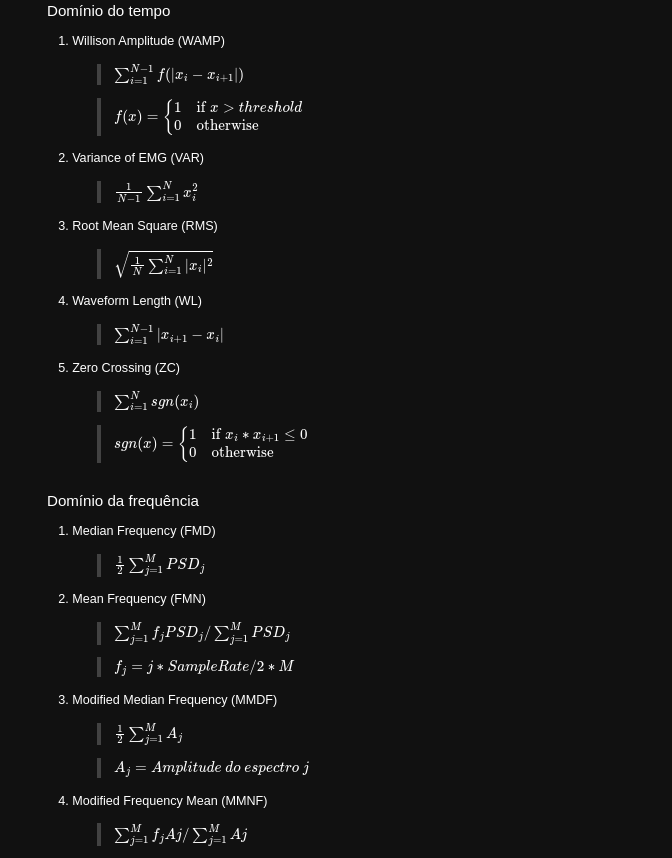

In [3053]:
from math import prod
import numpy as np

# funções auxiliares

def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2

def f_j(w):
    return (np.arange(1, w.shape[-1]+1) * 200)/ (2 * w.shape[-1])

## Dominio do tempo

def wamp(x, threshold):
    f_x = np.diff(x)
    return np.sum(np.abs(f_x) > threshold, axis=-1)

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape) - 1))

def wl(x):
    return np.abs(np.diff(x, axis=-1)).sum(axis=-1)

def zc(x):
    sgn = np.sign(x)
    return np.sum(np.diff(sgn, axis=-1) != 0, axis=-1)

## Dominio da Frequencia

def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def fmn(w):
    return np.sum(f_j(w) * PSD(w)) / fmd(w)*2

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

def mmnf(w):
    return np.sum(f_j(w) * np.abs(w), axis=-1) / mmdf(w)*2

##### Implementação do vetor


In [3054]:

x = np.load("dataset/segmented_data_t.npy")
w = np.load("dataset/segmented_data_f.npy")

print("Shape dos vetores originais:", x.shape, w.shape)

Shape dos vetores originais: (56, 2, 14, 64) (56, 2, 14, 33)


##### Aplicando características

In [3055]:
data_var = var(x)
data_rms = rms(w)

data_fmd = fmd(w)
data_mmdf = mmdf(w)

data_var.shape, data_rms.shape, data_fmd.shape, data_mmdf.shape

# 2 -> eletrodos

((56, 2, 14), (56, 2, 14), (56, 2, 14), (56, 2, 14))

##### União do vetor de características inicial

In [3056]:
features = np.array([data_var , data_rms , data_fmd , data_mmdf])

#Organização das dimensões (vetor de características deve possuir duas dimensões)
features = features.transpose(1, 3, 0, 2)

#criar vetor de características definitivo
features = features.reshape(features.shape[0] * features.shape[1],
                            features.shape[2] * features.shape[3])

features.shape

(784, 8)

#### *Tarefa 3* : Realização da normalização dos dados utilizando ferramentas já conhecidas (standardScaler)

In [3057]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
normalized_feat = ss.fit_transform(features)

normalized_feat.shape

(784, 8)

##### Criação do vetor de *labels* 

In [3058]:
from sklearn.preprocessing import OneHotEncoder

labels_str = ['dir', 'esq', 'cima', 'baixo', 'cima', 'baixo',
'baixo', 'esq', 'dir', 'baixo', 'dir', 'dir', 'esq', 'cima',
'baixo', 'cima', 'esq', 'dir', 'cima', 'esq', 'baixo', 'esq',
'dir', 'esq', 'cima', 'dir', 'cima', 'baixo']

# transformando para numérico
lab_dict = {'dir': 0, 'esq': 1, 'cima': 2, 'baixo': 3}
labels_num = [lab_dict[item] for item in labels_str]

print(labels_num)

# criação do vetor de labels final
y = np.repeat(labels_num, int(features.shape[0] / len(labels_num)))
print(len(y))

[0, 1, 2, 3, 2, 3, 3, 1, 0, 3, 0, 0, 1, 2, 3, 2, 1, 0, 2, 1, 3, 1, 0, 1, 2, 0, 2, 3]
784


#### *Tarefa 4* : Realização da seleção de características, utilizando ferramentas já conhecidas

#### **Aplicando método de seleção de característica (por exemplo, Select Kbest)**

In [3059]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=8)
selected_data = selector.fit_transform(features, y)

print(selected_data.shape)


(784, 8)


#### *Tarefa 5*: Realização da classificação utilizando `SVM`.

A utilização do SVM padrão, sem qualquer modificação, estava levando tempo demais. 16 minutos era o tempo da execução, o que se torna iniviável, considerando a necessidade futura de "podar" os dados a fim de obter uma maior precisão da classificação, conforme orientado em sala de aula. Portanto, em busca de uma melhor utilização do SVM e com ambos os integrantes da dupla cursando a matéria de Aprendizagem de Máquina, do professor Juliano Foleiss, decidiu-se por testar a viabilidade de uma implementação alternativa do SVM.

Sabe-se que o SVM é um algoritmo de classificação focado em encontrar um hiperplano que melhor separa as classes em um espaço de características, onde cada característica é representada por uma dimensão num espaço multidimensional, e o hiperplano é a fronteira de decisão que separa as classes. No caso de dados bidimensionais, é uma linha; em três dimensões, é um plano. Em espaços de dimensões mais altas, é um hiperplano.

O SVM procura encontrar um hiperplano de decisão que maximize a margem entre as classes, ou seja, a distância entre o hiperplano e os pontos de dados mais próximos de cada classe.
Nesta implememntação, decide-se por utilizar o **kernel *rbf***, substituindo o padrão *linear*, utilizado até então. Este kernel utiliza um parâmetro ***gamma***,  que controla a influência da distância entre os pontos no cálculo da margem suave, e o parâmetro ***C***, que determina a **largura da margem**, variando entre os valores 1, 10, 100, 1000 e 10000. Itera-se por estes valores, buscando a melhor combinação entre os parâmetros **gamma** e **C**.

#### **Classificação (SVM)**

In [3060]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from joblib import Parallel, delayed
from tqdm.notebook import tqdm
import itertools

#Cs e gammas são listas com os valores a serem avaliados para os respectivos parâmetros.
def selecionar_melhor_svm(Cs, gammas, X_treino : np.ndarray, X_val : np.ndarray, 
                          y_treino : np.ndarray, y_val : np.ndarray, n_jobs=4):
    
    def treinar_svm(C, gamma, X_treino, X_val, y_treino, y_val):
        svm = SVC(C=C, gamma=gamma)
        svm.fit(X_treino, y_treino)
        pred = svm.predict(X_val)
        return accuracy_score(y_val, pred)
    
    #gera todas as combinações de parametros C e gamma, de acordo com as listas de valores recebidas por parametro.
    #Na prática faz o produto cartesiano entre Cs e gammas.
    combinacoes_parametros = list(itertools.product(Cs, gammas))
    
    #Treinar modelos com todas as combinações de C e gamma
    acuracias_val = Parallel(n_jobs=n_jobs)(delayed(treinar_svm)
                                       (c, g, X_treino, X_val, y_treino, y_val) for c, g in combinacoes_parametros)       
    
    melhor_val = max(acuracias_val)
    #Encontrar a combinação que levou ao melhor resultado no conjunto de validação
    melhor_comb = combinacoes_parametros[np.argmax(acuracias_val)]   
    melhor_c = melhor_comb[0]
    melhor_gamma = melhor_comb[1]
    
    #Treinar uma SVM com todos os dados de treino e validação usando a melhor combinação de C e gamma.
    svm = SVC(C=melhor_c, gamma=melhor_gamma)
    svm.fit(np.vstack((X_treino, X_val)), [*y_treino, *y_val])

    return svm, melhor_comb, melhor_val

#Implementa a validação cruzada para avaliar o desempenho da SVM na base de dados com as instâncias X e as saídas y.
#cv_splits indica o número de partições que devem ser criadas.
#Cs é a lista com os valores C que devem ser avaliados na busca exaustiva de parametros para a SVM.
#gammas s é a lista com os valores gamma que devem ser avaliados na busca exaustiva de parametros para a SVM.
def do_cv_svm(X, y, cv_splits, Cs=[1], gammas=['scale']):

    skf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=1)

    acuracias = []
    
    pgb = tqdm(total=cv_splits, desc='Folds avaliados')
    
    for treino_idx, teste_idx in skf.split(X, y):

        X_treino = X[treino_idx]
        y_treino = y[treino_idx]

        X_teste = X[teste_idx]
        y_teste = y[teste_idx]

        X_treino, X_val, y_treino, y_val = train_test_split(X_treino, y_treino, stratify=y_treino, test_size=0.2, random_state=1)

        ss = StandardScaler()
        ss.fit(X_treino)
        X_treino = ss.transform(X_treino)
        X_teste = ss.transform(X_teste)
        X_val = ss.transform(X_val)

        svm, _, _ = selecionar_melhor_svm(Cs, gammas, X_treino, X_val, y_treino, y_val)
        pred = svm.predict(X_teste)

        acuracias.append(accuracy_score(y_teste, pred))
        
        pgb.update(1)
        
    pgb.close()
    
    return acuracias


In [3061]:
def calcular_estatisticas(resultados):
    return np.mean(resultados), np.std(resultados), np.min(resultados), np.max(resultados)

def imprimir_estatisticas(resultados):
    media, desvio, mini, maxi = calcular_estatisticas(resultados)
    print("Resultados: %.2f +- %.2f, min: %.2f, max: %.2f" % (media, desvio, mini, maxi))

In [3062]:

accs_svm = do_cv_svm(selected_data, y, 10, Cs=[1, 10, 100, 1000], gammas=['scale', 'auto', 2e-2, 2e-3, 2e-4])

Folds avaliados:   0%|          | 0/10 [00:00<?, ?it/s]

In [3063]:
imprimir_estatisticas(accs_svm)

Resultados: 0.37 +- 0.06, min: 0.27, max: 0.47
